In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['employee_retention_data.csv']


In [3]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.preprocessing import OneHotEncoder

from pydotplus import graph_from_dot_data

from io import StringIO
from IPython.display import Image

from matplotlib import ticker
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from pylab import rcParams

%matplotlib inline
rcParams['figure.figsize'] = 8, 6
sns.set_style('darkgrid')

In [4]:
employee_df = pd.read_csv('../input/employee_retention_data.csv')

In [5]:
employee_df.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaN
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22


In [6]:
employee_df.company_id = employee_df.company_id.astype('category')
employee_df.join_date = pd.to_datetime(employee_df.join_date)
employee_df.quit_date = pd.to_datetime(employee_df.quit_date)

In [7]:
employee_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24702 entries, 0 to 24701
Data columns (total 7 columns):
employee_id    24702 non-null float64
company_id     24702 non-null category
dept           24702 non-null object
seniority      24702 non-null int64
salary         24702 non-null float64
join_date      24702 non-null datetime64[ns]
quit_date      13510 non-null datetime64[ns]
dtypes: category(1), datetime64[ns](2), float64(2), int64(1), object(1)
memory usage: 1.2+ MB


In [8]:
employee_df.describe()

,employee_id,seniority,salary
count,24702.000000,24702.000000,24702.000000
mean,501604.403530,14.127803,138183.345478
std,288909.026101,8.089520,76058.184573
min,36.000000,1.000000,17000.000000
25%,250133.750000,7.000000,79000.000000
50%,500793.000000,14.000000,123000.000000
75%,753137.250000,21.000000,187000.000000
max,999969.000000,99.000000,408000.000000


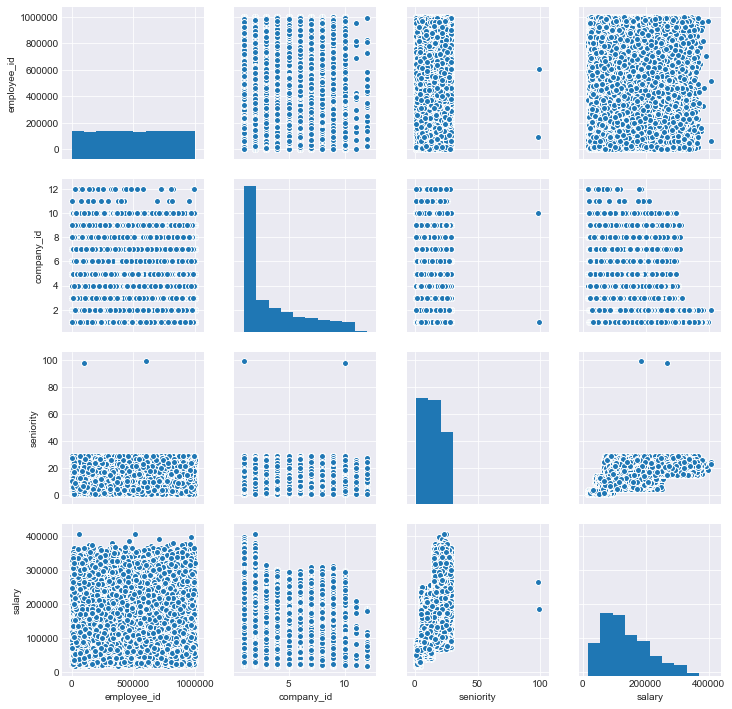

In [9]:
sns.pairplot(employee_df)

In [10]:
dates = pd.date_range(start='2011/01/24', end='2015/12/13')
companies = employee_df.company_id.cat.categories
headcount_df = pd.DataFrame(index=pd.MultiIndex
                            .from_product([dates, companies], 
                                          names=['day', 'company_id']), 
                           )#.reset_index()

In [11]:
employee_join = employee_df.groupby(['join_date','company_id']).agg({'employee_id':'count'}).rename(columns={'employee_id':'employees_joined'})
employee_quit = employee_df.groupby(['quit_date','company_id']).agg({'employee_id':'count'}).rename(columns={'employee_id':'employees_quit'})

employee_join.index.rename(['day','company_id'], inplace=True)
employee_quit.index.rename(['day','company_id'], inplace=True)

In [12]:
headcount_df = headcount_df.join(employee_join).join(employee_quit)
headcount_df.fillna(0, inplace=True)

In [13]:
headcount_df = headcount_df.groupby('company_id').cumsum()
headcount_df['employee_headcount'] = headcount_df.employees_joined - headcount_df.employees_quit
headcount_df.drop(['employees_joined','employees_quit'], axis=1, inplace=True)

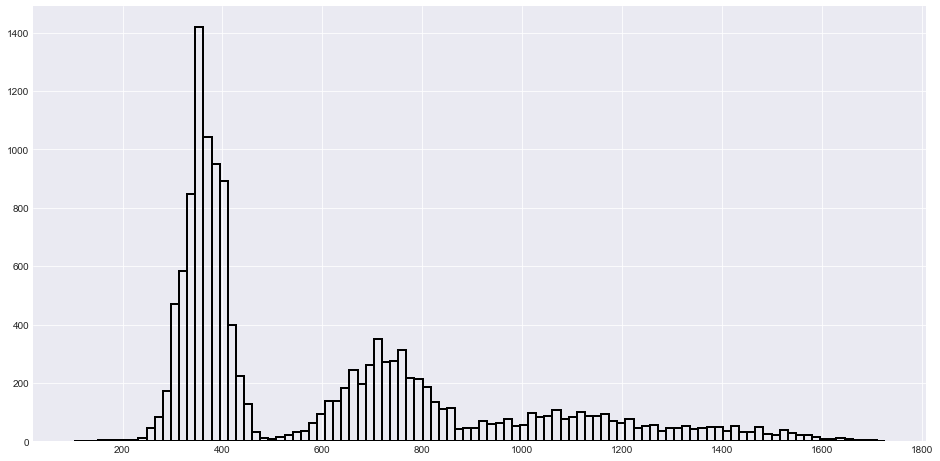

In [14]:
employee_df['employment_length'] = (employee_df.dropna(subset=['quit_date'])['quit_date'] - employee_df.dropna(subset=['quit_date'])['join_date'])
employee_df.employment_length.dt.days.hist(bins=100, fill=False, linewidth=2, figsize=[16,8])

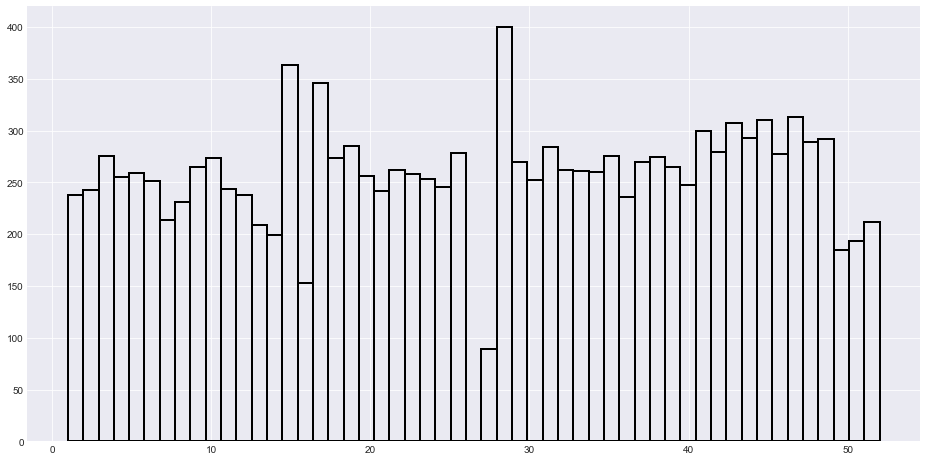

In [15]:
employee_df.quit_date.dropna().dt.weekofyear.hist(bins=53, fill=False, linewidth=2, figsize=[16,8])

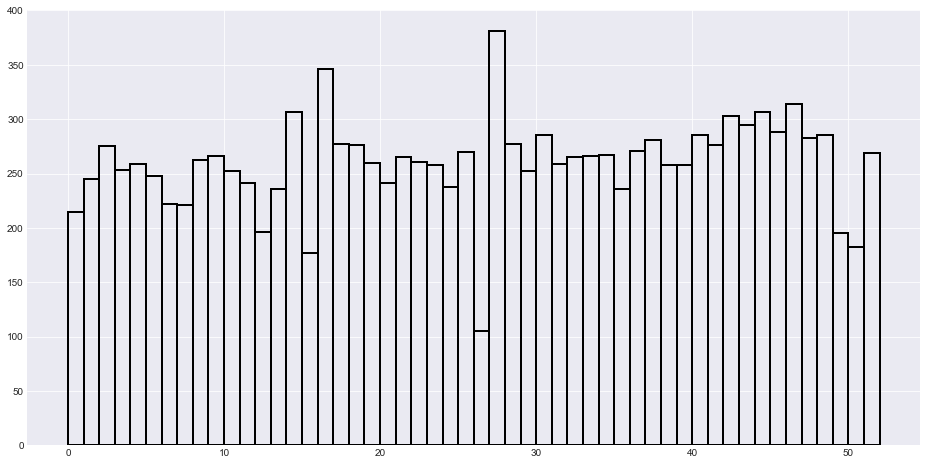

In [16]:
employee_df.quit_date.dropna().dt.strftime('%U').astype('int').hist(bins=52,fill=False, linewidth=2, figsize=[16,8])

In [17]:
employee_df = employee_df.loc[employee_df.join_date < pd.to_datetime('2015/12/13') - pd.Timedelta(days=365+31)]

In [18]:
employee_df['early_quitter'] = ((employee_df.quit_date.isna()) | (employee_df.quit_date - employee_df.join_date > pd.Timedelta(days=365+31))).astype('int')

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [19]:
employee_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19270 entries, 0 to 24701
Data columns (total 9 columns):
employee_id          19270 non-null float64
company_id           19270 non-null category
dept                 19270 non-null object
seniority            19270 non-null int64
salary               19270 non-null float64
join_date            19270 non-null datetime64[ns]
quit_date            13331 non-null datetime64[ns]
employment_length    13331 non-null timedelta64[ns]
early_quitter        19270 non-null int64
dtypes: category(1), datetime64[ns](2), float64(2), int64(2), object(1), timedelta64[ns](1)
memory usage: 1.3+ MB


In [20]:
features = ['company_id','dept','seniority','salary']
X = employee_df[features]
y = employee_df['early_quitter']

In [21]:
X = pd.get_dummies(X)

In [22]:
clf = DecisionTreeClassifier(max_depth=2, 
                             class_weight='balanced',
                             min_samples_leaf=30)
clf.fit(X,y)
print(clf.score(X, y))

0.46242864556305135


In [23]:
outfile = 'DecisionTreeClassifier.dot'
export_graphviz(clf, feature_names=X.columns, 
                class_names=['0', '1'], filled=True, 
                out_file=outfile,
                special_characters=True)
os.system('dot -Tpdf DecisionTreeClassifier.dot -o DecisionTreeClassifier.pdf');

tree = export_graphviz(clf, feature_names=X.columns, 
                       class_names=['0', '1'], filled=True, rounded=True,
                       out_file=None, special_characters=True, rotate=True)

graph = graph_from_dot_data(tree)
Image(graph.create_png())

InvocationException: GraphViz's executables not found

In [24]:
employee_df['salary_percentile'] = pd.qcut(employee_df['salary'],50, labels=np.linspace(1,50))

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [25]:
employee_df.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,employment_length,early_quitter,salary_percentile
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,585 days,1,15.0
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,340 days,0,37.0
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaT,NaT,1,19.0
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,389 days,0,23.0
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,1040 days,1,47.0


In [26]:
data_proportion_by_percentile = (employee_df[employee_df.early_quitter == 0].groupby('salary_percentile').agg({'early_quitter':'count'}) /
                                 employee_df.groupby('salary_percentile').agg({'early_quitter':'count'})
                                ).rename(columns={'early_quitter':'proportion_early_quitters'})

/anaconda2/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


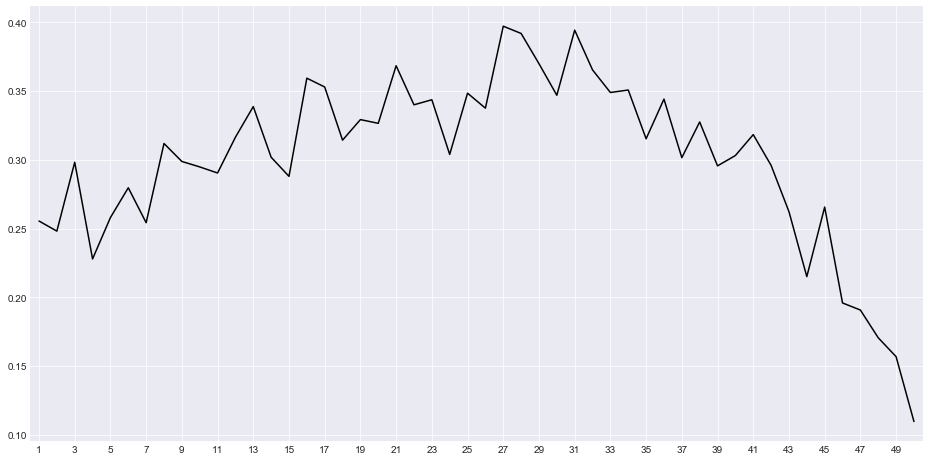

In [27]:
plt.figure(figsize=[16,8])
plt.plot(data_proportion_by_percentile.index.astype('int'), 
         data_proportion_by_percentile.proportion_early_quitters,
        'k')
plt.grid('on')
plt.xticks(np.arange(1,50,2, dtype='int'))
plt.gca().set_xlim([0.5,50.5]);